In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load all datasets
file_deaths_population = "../data/processed/States_Deaths_Populations.csv"
file_poverty = "../data/processed/US_Poverty_Rate.csv"
file_income_per_capita = "../data/processed/Personal_Income_Per_Capita.csv"
file_health_care = "../data/processed/Personal_Health_Care_Per_Capita.csv"
file_median_income = "../data/processed/Median_Household_Income.csv"

# Read CSV files
df_deaths_population = pd.read_csv(file_deaths_population)
df_poverty = pd.read_csv(file_poverty)
df_income_per_capita = pd.read_csv(file_income_per_capita)
df_health_care = pd.read_csv(file_health_care)
df_median_income = pd.read_csv(file_median_income)

# Reshape "Income Per Capita" dataset to long format
df_income_per_capita_long = df_income_per_capita.melt(id_vars=["State"], var_name="Year", value_name="Income Per Capita")

# Convert "Year" to integer for consistency
df_income_per_capita_long["Year"] = df_income_per_capita_long["Year"].astype(int)

# Try merging all datasets
df_master = df_deaths_population.merge(df_poverty, on=["State", "Year"], how="left")
df_master = df_master.merge(df_income_per_capita_long, on=["State", "Year"], how="left")
df_master = df_master.merge(df_health_care, on=["State", "Year"], how="left")
df_master = df_master.merge(df_median_income, on=["State", "Year"], how="left")

# Recalculate Proportional Death Rate (deaths per 100,000 population)
df_master["Proportional Death Rate"] = (df_master["Deaths"] / df_master["Population"]) * 100000

print(df_master.head())

   Year       State  Deaths  Population  Poverty Rate  Income Per Capita  \
0  1999     Alabama   80246     4430141          15.2              23296   
1  1999      Alaska    4782      624779           7.6              29941   
2  1999     Arizona   71846     5023823          12.2              24866   
3  1999    Arkansas   49937     2651860          14.7              21842   
4  1999  California  415533    33499204          14.0              30529   

   Spending  Median Income  Proportional Death Rate  
0    3689.0        36251.0              1811.364469  
1    4076.0        51396.0               765.390642  
2    3068.0        36995.0              1430.106116  
3    3517.0        29682.0              1883.093376  
4    3436.0        43629.0              1240.426489  


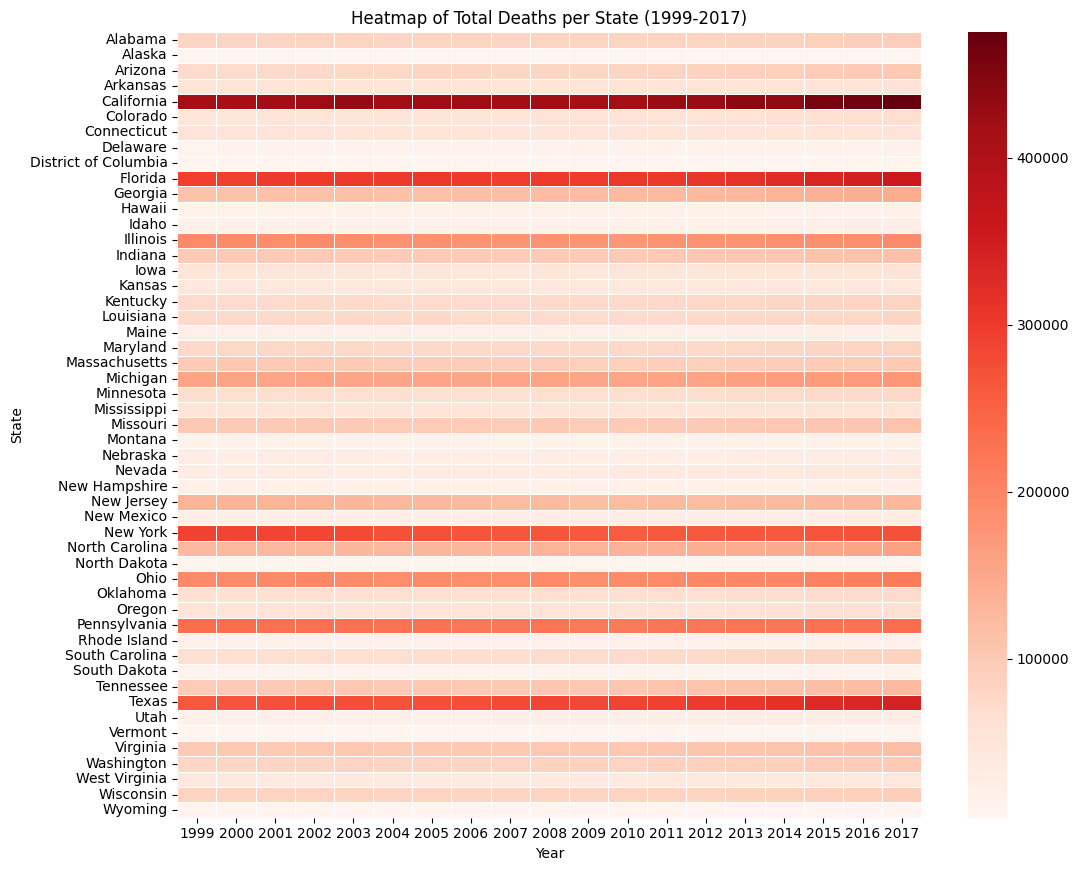

In [33]:
# Step 1: Create a heatmap for total deaths per state over time
heatmap_data_deaths = df_master.pivot(index="State", columns="Year", values="Deaths")

plt.figure(figsize=(12, len(heatmap_data_deaths) * 0.2))
sns.heatmap(heatmap_data_deaths, cmap="Reds", annot=False, linewidths=0.5)
plt.title("Heatmap of Total Deaths per State (1999-2017)")
plt.xlabel("Year")
plt.ylabel("State")
plt.show()


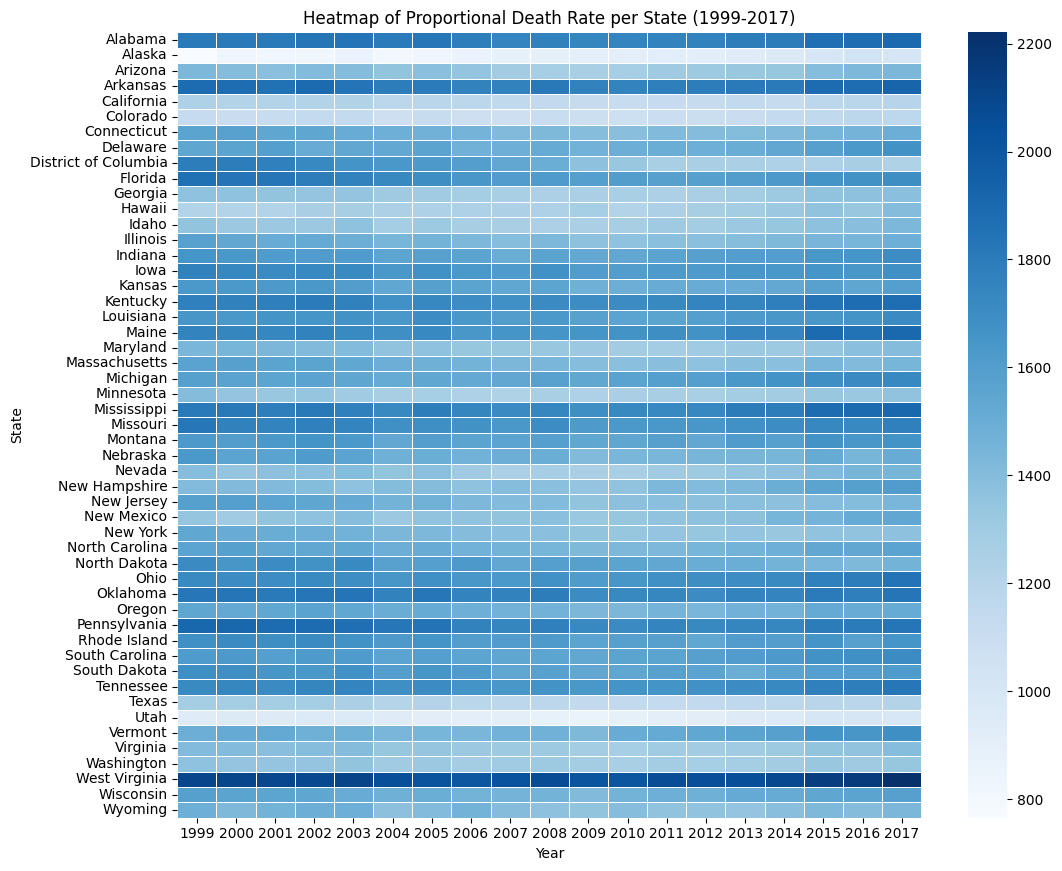

In [34]:
# Step 2: # Recalculate Proportional Death Rate (deaths per 100,000 population)
heatmap_data_proportional = df_master.pivot(index="State", columns="Year", values="Proportional Death Rate")

plt.figure(figsize=(12, len(heatmap_data_proportional) * 0.2))
sns.heatmap(heatmap_data_proportional, cmap="Blues", annot=False, linewidths=0.5)
plt.title("Heatmap of Proportional Death Rate per State (1999-2017)")
plt.xlabel("Year")
plt.ylabel("State")
plt.show()

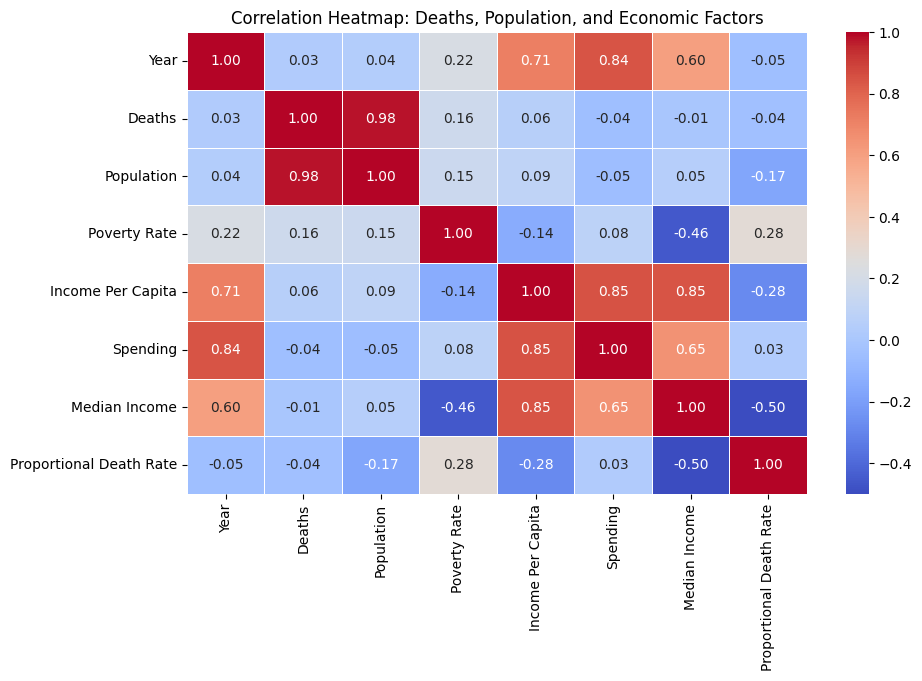

In [35]:
# Compute correlation matrix between deaths, population
numeric_df = df_master.select_dtypes(include=["number"])

# Compute correlation matrix for deaths, population, and economic factors
correlation_matrix = numeric_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Deaths, Population, and Economic Factors")
plt.show()

1. Deaths vs. Population → Strong positive correlation
This is expected because larger states have more total deaths.
2️. Proportional Death Rate vs. Population → Weak negative correlation
Suggests that larger states tend to have lower deaths per capita.
3️. Poverty Rate vs. Proportional Death Rate → Positive correlation
Higher poverty rates may be linked to higher death rates.
4️. Income Per Capita vs. Proportional Death Rate → Negative correlation
Suggests that wealthier states may have lower death rates.
5️. Healthcare Spending vs. Death Rates → Needs further investigation
The correlation may indicate whether higher spending actually reduces mortality.

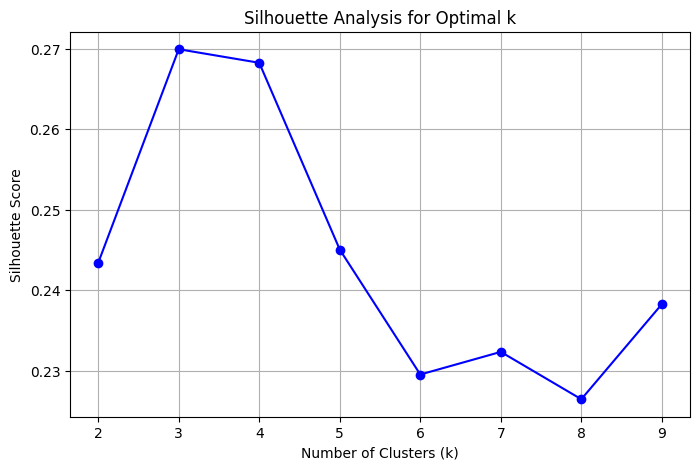

3


In [36]:
# Select relevant features for clustering
clustering_features = df_master[["Proportional Death Rate", "Poverty Rate", "Income Per Capita", "Spending", "Population"]]

# Handle missing values by filling with the mean
clustering_features = clustering_features.fillna(clustering_features.mean())

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Define the range of k values to test
k_values = range(2, 10)  # Testing cluster sizes from 2 to 9
silhouette_scores = []

# Iterate over different k values and compute the silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores to find the best k
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="-", color="blue")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.grid(True)
plt.show()

# Find the optimal k with the highest silhouette score
optimal_k = k_values[np.argmax(silhouette_scores)]
print(optimal_k)



         Proportional Death Rate  Poverty Rate  Income Per Capita  \
Cluster                                                             
0                    1321.583336     14.843284       41619.089552   
1                    1559.799680     13.202841       32420.810606   
2                    1453.853148     11.420053       47106.189840   

            Spending    Population  
Cluster                             
0        6547.582090  2.567077e+07  
1        5476.196970  4.594149e+06  
2        8255.064171  4.323660e+06  


<Figure size 1200x600 with 0 Axes>

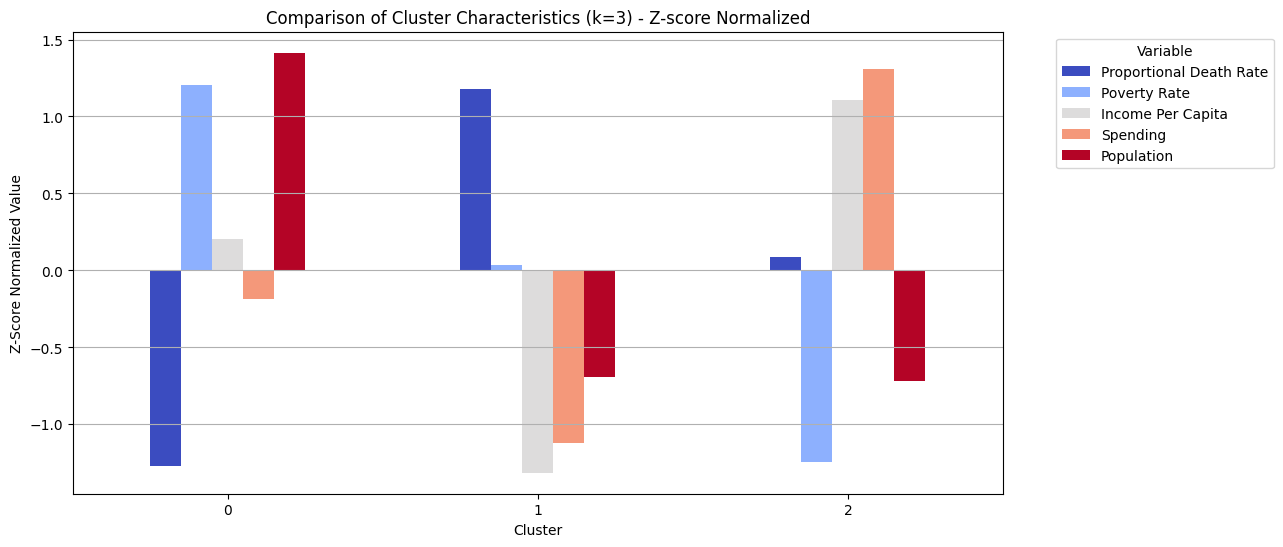

In [37]:

# Run K-Means Clustering with the optimal k = 3 (best separation)
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_master["Cluster"] = kmeans.fit_predict(scaled_features)

# Compute the mean values of key variables for each cluster (k=3) to interpret their meaning
cluster_characteristics_k3 = df_master.groupby("Cluster")[
    ["Proportional Death Rate", "Poverty Rate", "Income Per Capita", "Spending", "Population"]
].mean()

print(cluster_characteristics_k3)

# Cluster 0 (Low Mortality, Moderate Income States) - resilient systems or demographics
# Cluster 1 (Highest Mortality, Lowest Income States) - Economic and healthcare struggles → high mortality.
# Cluster 2 (Moderate Mortality, Highest Income States) - disparities or aging effects
cluster_characteristics_zscore = pd.DataFrame(
    scaler.fit_transform(cluster_characteristics_k3),
    columns=cluster_characteristics_k3.columns,
    index=cluster_characteristics_k3.index
)

# Plot Z-score normalized data
plt.figure(figsize=(12, 6))
cluster_characteristics_zscore.plot(kind="bar", figsize=(12, 6), colormap="coolwarm")
plt.xlabel("Cluster")
plt.ylabel("Z-Score Normalized Value")
plt.title("Comparison of Cluster Characteristics (k=3) - Z-score Normalized")
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


         Proportional Death Rate  Poverty Rate  Income Per Capita  \
Cluster                                                             
0                    1321.583336     14.843284       41619.089552   
1                    1559.799680     13.202841       32420.810606   
2                    1453.853148     11.420053       47106.189840   

            Spending    Population  
Cluster                             
0        6547.582090  2.567077e+07  
1        5476.196970  4.594149e+06  
2        8255.064171  4.323660e+06  


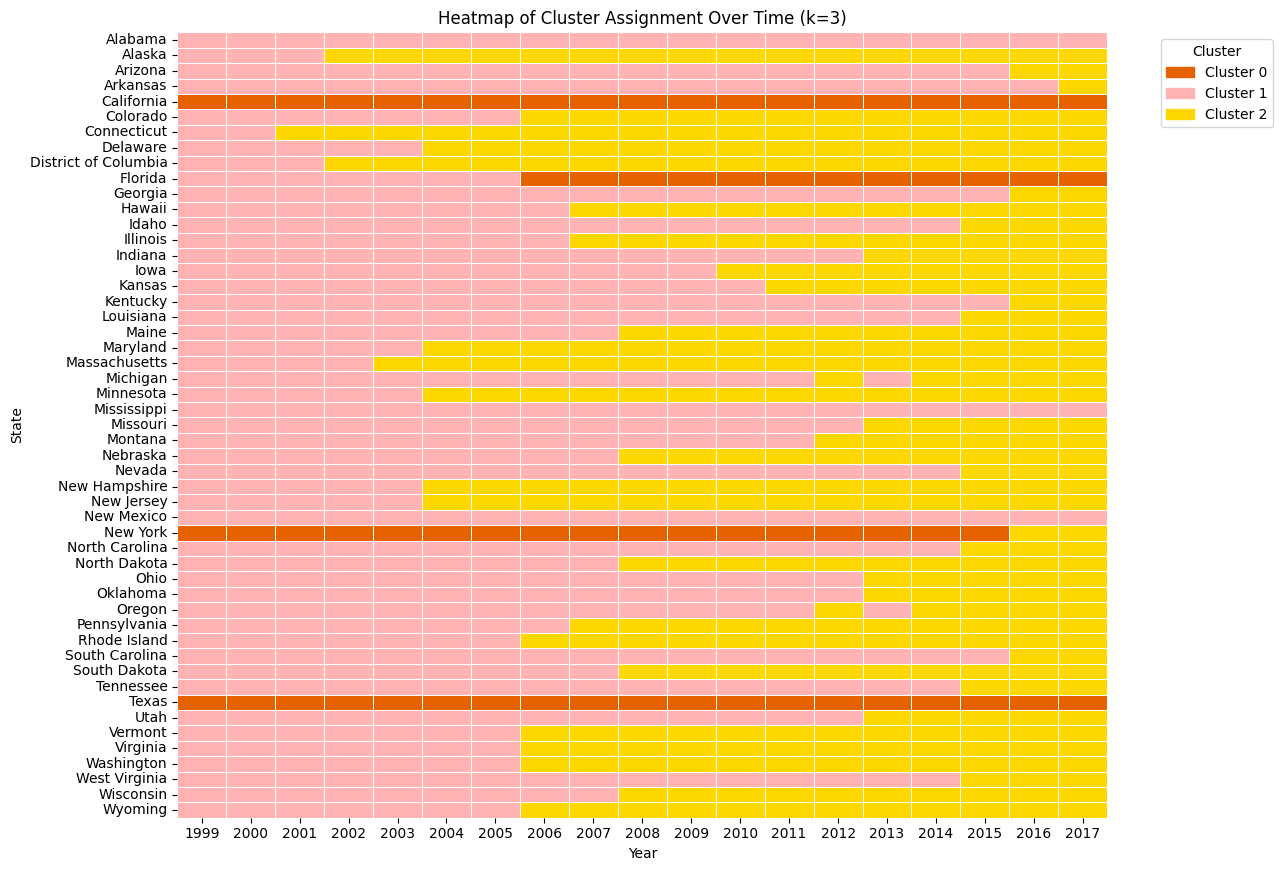

In [38]:
# Run K-Means Clustering with the optimal k = 3 (best separation)
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_master["Cluster"] = kmeans.fit_predict(scaled_features)

# Compute the mean values of key variables for each cluster
cluster_characteristics_k3 = df_master.groupby("Cluster")[
    ["Proportional Death Rate", "Poverty Rate", "Income Per Capita", "Spending", "Population"]
].mean()

print(cluster_characteristics_k3)

# Create a heatmap to visualize the cluster distribution over time
cluster_heatmap_data = df_master.pivot_table(index="State", columns="Year", values="Cluster")

# Define a discrete colormap for clusters 0, 1, 2
cluster_colors = ["#E66100", "#FFB3B3", "#FFD700"]  # Assign colors to clusters
cmap = ListedColormap(cluster_colors)

# Create the heatmap
plt.figure(figsize=(12, len(cluster_heatmap_data) * 0.2))
ax = sns.heatmap(cluster_heatmap_data, cmap=cmap, annot=False, linewidths=0.5, cbar=False)

# Create a custom legend
legend_patches = [Patch(color=cluster_colors[i], label=f"Cluster {i}") for i in range(3)]
plt.legend(handles=legend_patches, title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

# Titles and labels
plt.title("Heatmap of Cluster Assignment Over Time (k=3)")
plt.xlabel("Year")
plt.ylabel("State")

# Show plot
plt.show()

         Normalized Income Per Capita  Normalized Spending  \
Cluster                                                      
0                           -0.061080            -0.956422   
1                            1.102823             1.101810   
2                           -0.639574            -0.172592   

         Normalized Proportional Death Rate  Normalized Poverty Rate  \
Cluster                                                                
0                                 -1.013251                -0.098774   
1                                 -0.355792                -0.671900   
2                                  0.744384                 0.460496   

         Normalized Population  
Cluster                         
0                     0.545863  
1                    -0.282164  
2                    -0.112550  


<Figure size 1200x600 with 0 Axes>

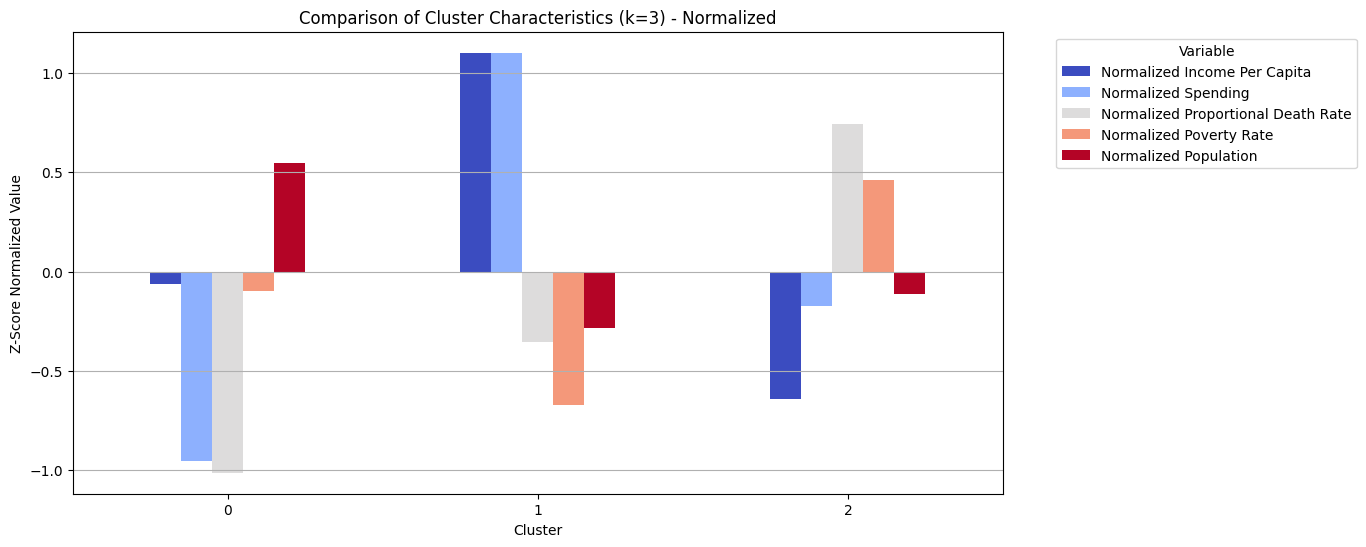

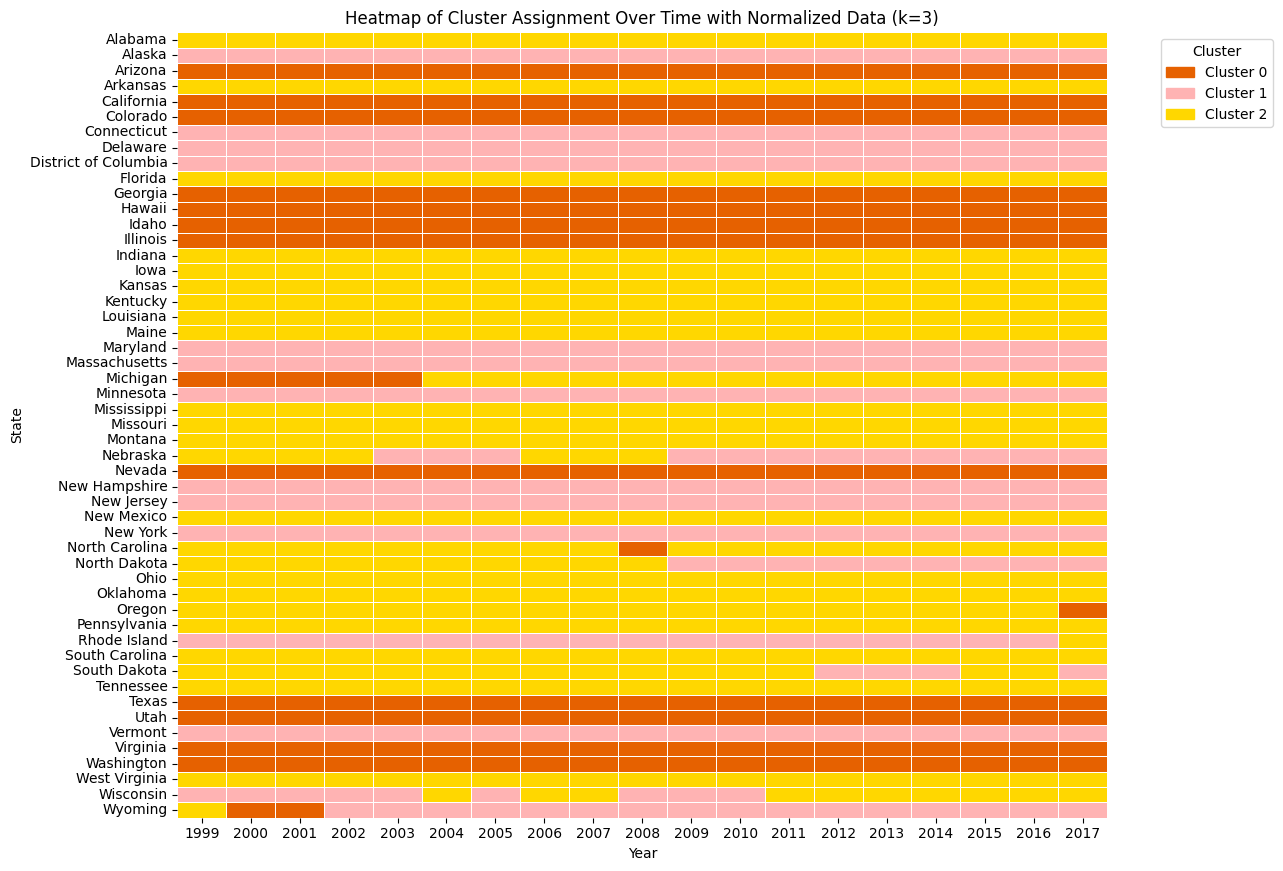

In [ ]:
# Normalize selected columns by year
variables_to_normalize = ["Income Per Capita", "Spending", "Proportional Death Rate", "Poverty Rate", "Population"]
df_normalized = df_master.copy()

for var in variables_to_normalize:
    df_normalized[f"Normalized {var}"] = df_normalized.groupby("Year")[var].transform(
        lambda x: (x - x.mean()) / x.std()
    )
    
    
# Select the normalized variables for clustering
normalized_features = [
    "Normalized Income Per Capita",
    "Normalized Spending",
    "Normalized Proportional Death Rate",
    "Normalized Poverty Rate",
    "Normalized Population",
]
    
scaler = StandardScaler()
scaled_normalized_features = scaler.fit_transform(df_normalized[normalized_features])

# Re-run K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_normalized["Cluster"] = kmeans.fit_predict(scaled_normalized_features)

# Display the new cluster characteristics
cluster_characteristics_normalized = df_normalized.groupby("Cluster")[
    normalized_features
].mean()

print(cluster_characteristics_normalized)

# Cluster 0: Moderate Income, Low Mortality
# Cluster 1: Highest Income, Moderate mortality
# Cluster 2: Lowest Income, Highest mortality

# Plot Z-score normalized data
plt.figure(figsize=(12, 6))
cluster_characteristics_normalized.plot(kind="bar", figsize=(12, 6), colormap="coolwarm")
plt.xlabel("Cluster")
plt.ylabel("Z-Score Normalized Value")
plt.title("Comparison of Cluster Characteristics (k=3) - Normalized")
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

# Create a heatmap to visualize the cluster distribution over time
cluster_heatmap_normalized_data = df_normalized.pivot_table(index="State", columns="Year", values="Cluster")

# Define a discrete colormap for clusters 0, 1, 2
cluster_colors = ["#E66100", "#FFB3B3", "#FFD700"]  # Assign colors to clusters
cmap = ListedColormap(cluster_colors)

# Create the heatmap
plt.figure(figsize=(12, len(cluster_heatmap_normalized_data) * 0.2))
ax = sns.heatmap(cluster_heatmap_normalized_data, cmap=cmap, annot=False, linewidths=0.5, cbar=False)

# Create a custom legend
legend_patches = [Patch(color=cluster_colors[i], label=f"Cluster {i}") for i in range(3)]
plt.legend(handles=legend_patches, title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

# Titles and labels
plt.title("Heatmap of Cluster Assignment Over Time with Normalized Data (k=3)")
plt.xlabel("Year")
plt.ylabel("State")

# Show plot
plt.show()